In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DAILY_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "sales_daily.csv")
DATA_WEEKLY_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "sales_weekly.csv")
FIG_DIR = os.path.join(PROJECT_ROOT, "results", "figures")

os.makedirs(FIG_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("Project root:", PROJECT_ROOT)
print("Figures dir:", FIG_DIR)

Project root: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model
Figures dir: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures


In [ ]:
def load_timeseries_csv(path: str):
    """
    Load a CSV and infer:
    - date column
    - target numeric column (if not given)
    Returns: df, date_col, target_col
    """
    df = pd.read_csv(path)

    # Candidate date columns
    date_candidates = [
        "date", "Date", "ds",
        "sale_date_time", "sale_datetime", "timestamp", "time",
        "day", "week", "week_start", "period"
    ]
    date_col = next((c for c in date_candidates if c in df.columns), None)

    # If not found, try to guess: first column that parses well as datetime
    if date_col is None:
        for c in df.columns[:5]:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce")
                if parsed.notna().mean() > 0.8:
                    date_col = c
                    break
            except Exception:
                continue

    if date_col is None:
        raise ValueError(f"Could not infer a date column in {path}. Columns: {list(df.columns)}")

    # Parse date
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)

    # Candidate target columns (common names)
    target_candidates = [
        "quantity_sold", "Quantity_Sold", "qty", "quantity",
        "sales", "Sales", "y", "target", "value"
    ]
    target_col = next((c for c in target_candidates if c in df.columns), None)

    # If still not found, guess numeric column with highest variance (excluding IDs)
    if target_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        # Exclude likely ID-like columns
        numeric_cols = [c for c in numeric_cols if "id" not in c.lower()]
        if not numeric_cols:
            raise ValueError(f"Could not infer a numeric target column in {path}. Columns: {list(df.columns)}")
        target_col = df[numeric_cols].var().sort_values(ascending=False).index[0]

    return df, date_col, target_col

In [3]:
daily_df, daily_date_col, daily_target_col = load_timeseries_csv(DATA_DAILY_PATH)
weekly_df, weekly_date_col, weekly_target_col = load_timeseries_csv(DATA_WEEKLY_PATH)

print("DAILY:", DATA_DAILY_PATH)
print("  date_col  =", daily_date_col)
print("  target_col=", daily_target_col)
display(daily_df.head())
print("\nWEEKLY:", DATA_WEEKLY_PATH)
print("  date_col  =", weekly_date_col)
print("  target_col=", weekly_target_col)
display(weekly_df.head())

DAILY: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/raw/sales_daily.csv
  date_col  = datum
  target_col= N02BE


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday



WEEKLY: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/raw/sales_weekly.csv
  date_col  = datum
  target_col= N02BE


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [4]:
ATC_COLS = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]

# DAILY
daily = daily_df[["datum"] + ATC_COLS].copy()
daily["ds"] = pd.to_datetime(daily["datum"])
daily["y"] = daily[ATC_COLS].sum(axis=1)

daily = daily[["ds", "y"]].sort_values("ds")

# WEEKLY
weekly = weekly_df[["datum"] + ATC_COLS].copy()
weekly["ds"] = pd.to_datetime(weekly["datum"])
weekly["y"] = weekly[ATC_COLS].sum(axis=1)

weekly = weekly[["ds", "y"]].sort_values("ds")

print("Daily total demand rows:", len(daily))
print("Weekly total demand rows:", len(weekly))


Daily total demand rows: 2106
Weekly total demand rows: 302


In [5]:
def describe_ts(df, name):
    print(f"\n=== {name} Summary ===")
    print(df["y"].describe())
    print("Missing y:", df["y"].isna().sum())
    print("Duplicates dates:", df["ds"].duplicated().sum())

describe_ts(daily, "Daily")
describe_ts(weekly, "Weekly")


=== Daily Summary ===
count    2106.000000
mean       60.586659
std        21.561684
min         0.000000
25%        46.446750
50%        58.466500
75%        72.814250
max       198.950000
Name: y, dtype: float64
Missing y: 0
Duplicates dates: 0

=== Weekly Summary ===
count    302.000000
mean     422.501668
std       99.052693
min      153.507000
25%      345.968750
50%      409.086000
75%      479.077500
max      790.837167
Name: y, dtype: float64
Missing y: 0
Duplicates dates: 0


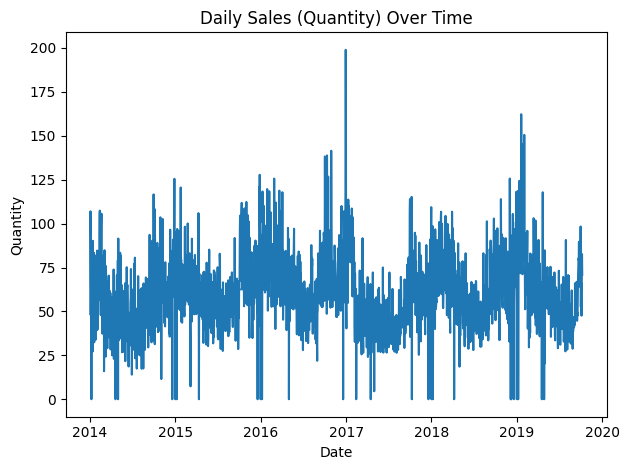

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_sales_over_time.png


In [6]:
plt.figure()
plt.plot(daily["ds"], daily["y"])
plt.title("Daily Sales (Quantity) Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_sales_over_time.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)

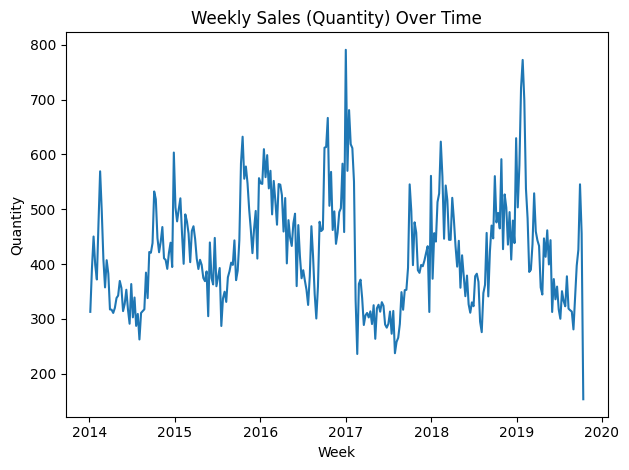

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/weekly_sales_over_time.png


In [7]:
plt.figure()
plt.plot(weekly["ds"], weekly["y"])
plt.title("Weekly Sales (Quantity) Over Time")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.tight_layout()
out = os.path.join(FIG_DIR, "weekly_sales_over_time.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)

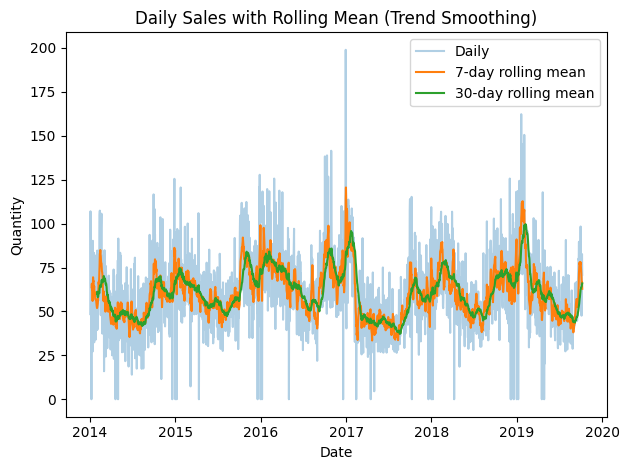

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_sales_rolling_mean.png


In [8]:
daily_rolling_7 = daily.set_index("ds")["y"].rolling(7).mean()
daily_rolling_30 = daily.set_index("ds")["y"].rolling(30).mean()

plt.figure()
plt.plot(daily["ds"], daily["y"], alpha=0.35, label="Daily")
plt.plot(daily_rolling_7.index, daily_rolling_7.values, label="7-day rolling mean")
plt.plot(daily_rolling_30.index, daily_rolling_30.values, label="30-day rolling mean")
plt.title("Daily Sales with Rolling Mean (Trend Smoothing)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_sales_rolling_mean.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)

In [9]:
# Build a complete daily date range and check gaps
daily_full = pd.date_range(start=daily["ds"].min(), end=daily["ds"].max(), freq="D")
daily_missing = daily_full.difference(pd.DatetimeIndex(daily["ds"]))

print("Missing daily dates:", len(daily_missing))
if len(daily_missing) > 0:
    print("First 15 missing:", list(daily_missing[:15]))

Missing daily dates: 0


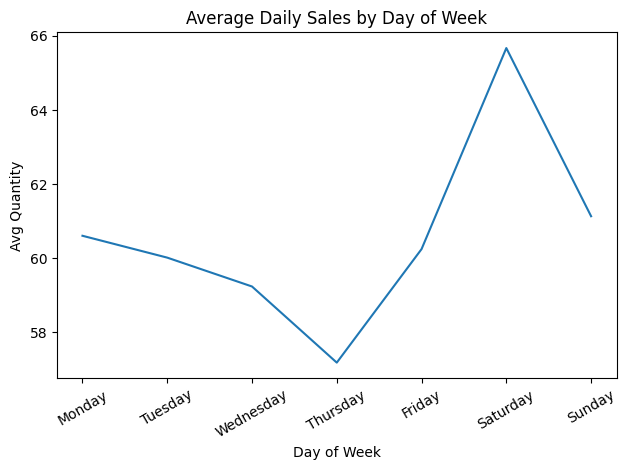

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_seasonality_day_of_week.png


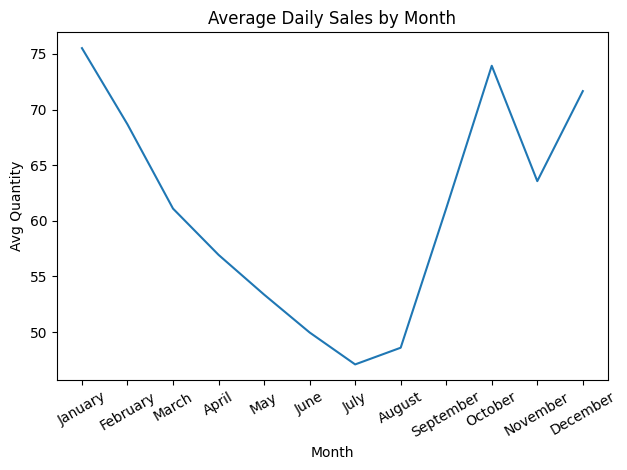

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_seasonality_by_month.png


In [10]:
tmp = daily.copy()
tmp["dow"] = tmp["ds"].dt.day_name()
tmp["month"] = tmp["ds"].dt.month_name()

# Day-of-week average
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_avg = tmp.groupby("dow")["y"].mean().reindex(dow_order)

plt.figure()
plt.plot(dow_avg.index, dow_avg.values)
plt.title("Average Daily Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Quantity")
plt.xticks(rotation=30)
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_seasonality_day_of_week.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

# Month average
month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
month_avg = tmp.groupby("month")["y"].mean().reindex(month_order)

plt.figure()
plt.plot(month_avg.index, month_avg.values)
plt.title("Average Daily Sales by Month")
plt.xlabel("Month")
plt.ylabel("Avg Quantity")
plt.xticks(rotation=30)
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_seasonality_by_month.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

IQR lower/upper: 6.8955000000000055 112.3655
Outlier points: 60


,ds,y
1093,2016-12-30,198.950000
1844,2019-01-20,162.283000
1094,2016-12-31,151.239000
1857,2019-02-02,150.508000
1851,2019-01-27,145.365000
1850,2019-01-26,141.659000
1031,2016-10-29,141.470000
1013,2016-10-11,138.819333
1004,2016-10-02,138.256000
725,2015-12-28,127.799000


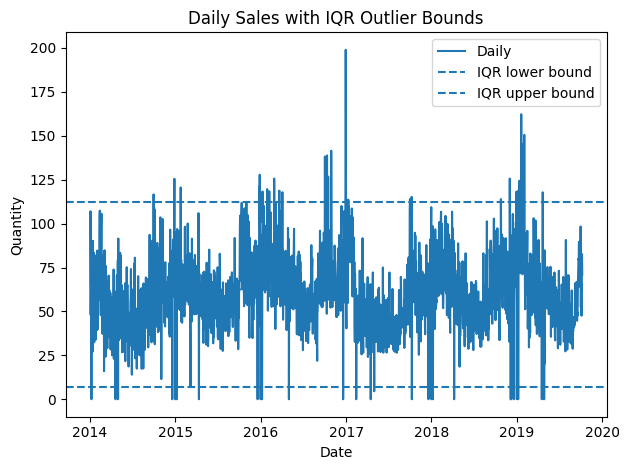

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_outlier_bounds_iqr.png


In [12]:
q1, q3 = daily["y"].quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = daily[(daily["y"] < lower) | (daily["y"] > upper)].copy()
print("IQR lower/upper:", lower, upper)
print("Outlier points:", len(outliers))

display(outliers.sort_values("y", ascending=False).head(10))

# Plot with thresholds
plt.figure()
plt.plot(daily["ds"], daily["y"], label="Daily")
plt.axhline(lower, linestyle="--", label="IQR lower bound")
plt.axhline(upper, linestyle="--", label="IQR upper bound")
plt.title("Daily Sales with IQR Outlier Bounds")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_outlier_bounds_iqr.png")
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)

The dataset spans six years (2014–2019) of continuous daily and weekly pharmaceutical sales with no missing timestamps or duplicate dates.

Strong annual seasonality is observed, with higher average demand during winter months (January–February and late Q4) and lower demand during summer months.

Weekly seasonality is present, with increased sales during weekends, particularly on Saturdays.

Daily sales exhibit high short-term volatility, while rolling averages reveal stable long-term seasonal and cyclical patterns.

IQR-based outlier analysis identified approximately 2–3% of observations as extreme values. These outliers occur predominantly during winter periods and are consistent with real-world demand surges rather than data errors.

Outliers are retained in the dataset to preserve realistic demand behavior and to evaluate the robustness of forecasting models under peak demand conditions.

The contrast between highly volatile daily data and smoother weekly aggregates motivates a comparative forecasting analysis across temporal granularities.